In [1]:
#load libraries

import numpy as np
import pandas as pd

### **Single Decision Tree**

In [30]:
#Read dataframe
df = pd.read_csv('titanic.csv', sep = ';')
print(df.shape)
print(df.head())

# Extract the target (injuried)
target = np.array(df.pop("Survived"))

(714, 7)
   Pclass  female   Age  SibSp  Parch     Fare  Survived
0       3       0  22.0      1      0   7.2500         0
1       1       1  38.0      1      0  71.2833         1
2       3       1  26.0      0      0   7.9250         1
3       1       1  35.0      1      0  53.1000         1
4       3       0  35.0      0      0   8.0500         0


In [6]:
#Splinting dataframe in training and test data (70/30 ratio)

from sklearn.model_selection import train_test_split

train, test, train_target, test_target = train_test_split(df, target, stratify = target, test_size = 0.3)
print(train.shape, test.shape, train_target.shape, test_target.shape)

(499, 6) (215, 6) (499,) (215,)


In [7]:
# Train tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(train, train_target)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 239 nodes with maximum depth 14.


In [8]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [9]:
#Couting classes prediction
from collections import Counter
print(Counter(predictions))

Counter({0: 131, 1: 84})


In [10]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_target, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_target, probs)}')

Train ROC AUC Score: 0.999925109838903
Test ROC AUC  Score: 0.740167025862069


In [11]:
#Plot ROC curve
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_target, [1 for _ in range(len(test_target))])
    baseline['precision'] = precision_score(test_target, [1 for _ in range(len(test_target))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_target, predictions)
    results['precision'] = precision_score(test_target, predictions)
    results['roc'] = roc_auc_score(test_target, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_target, train_predictions)
    train_results['precision'] = precision_score(train_target, train_predictions)
    train_results['roc'] = roc_auc_score(train_target, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_target, [1 for _ in range(len(test_target))])
    model_fpr, model_tpr, _ = roc_curve(test_target, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Recall Baseline: 1.0 Test: 0.68 Train: 0.99
Precision Baseline: 0.4 Test: 0.7 Train: 1.0
Roc Baseline: 0.5 Test: 0.74 Train: 1.0


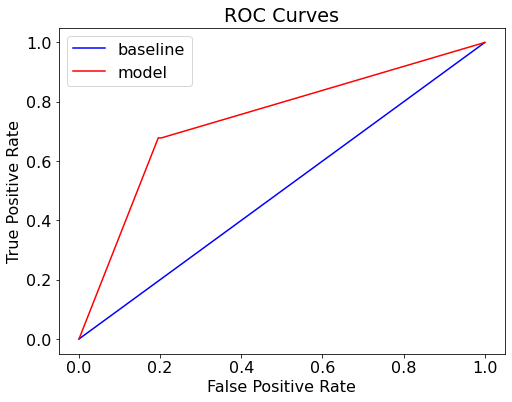

In [12]:
evaluate_model(predictions, probs, train_predictions, train_probs)

In [13]:
# Features importances
features = list(train.columns)

fi = pd.DataFrame({'feature': features, 'importance': tree.feature_importances_}).sort_values('importance', ascending = False)
fi.head()

,feature,importance
1,female,0.302757
2,Age,0.252527
5,Fare,0.247128
0,Pclass,0.095611
3,SibSp,0.063915


###**Random Forest**

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, max_features = 'sqrt', n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [26]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 209
Average maximum depth 15


In [27]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [28]:
#Couting classes prediction
from collections import Counter
predictions = model.predict(test)
print(Counter(predictions))

Counter({0: 138, 1: 77})


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Recall Baseline: 1.0 Test: 0.69 Train: 0.99
Precision Baseline: 0.4 Test: 0.78 Train: 1.0
Roc Baseline: 0.5 Test: 0.83 Train: 1.0


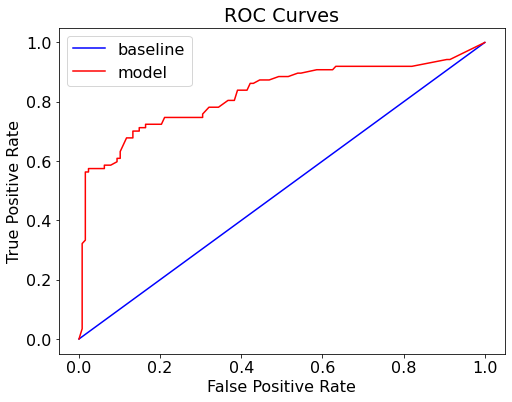

In [29]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [24]:
# Features importances

fi = pd.DataFrame({'feature': features, 'importance': model.feature_importances_}).sort_values('importance', ascending = False)
fi.head()

,feature,importance
5,Fare,0.287161
2,Age,0.282899
1,female,0.247084
0,Pclass,0.092152
3,SibSp,0.053163
